In [364]:
import cv2 as cv
import numpy as np
import math
import sys
from pathlib import Path
from matplotlib import pyplot as plt
from pyinpaint import Inpaint

In [547]:
# Digital image restoration:
# Equalize:
# Exposure - Too over or under - Histogram to view levels (
# Black levels - Not too dark
# Saturation
# Hue
# Colour correction^^^^
# Detect blur - Too blurry, no bueno, a little blurry, imbedded loop to fix by sharpening? Too much noise?
# Sharpen
# Save image
# Create mask:
# Create manual mask for damage to photo - physcial damage (inpaint or openCV) (Preferably open CV to run on lab)

In [895]:
# Import image
img_loc = 'Images/001.png'
path = Path(img_loc).stem
ext = Path(img_loc).suffix

img = cv2.imread(img_loc)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
imgshp = img.shape

# Thought I was going to use these at some stage
b=img[0]
g=img[1]
r=img[2]

# Detection phase
# Over exposed? Under exposed too far? Too blurry?
# If any, print cannot edit, too broken?
blurriness = cv2.Laplacian(img, cv2.CV_64F).var() #Detect blurriness with Laplacian

# Histogram of image
hist,bins = np.histogram(img.flatten(),256,[0,256])
undercheck = np.sum(hist[:24])
overcheck = np.sum(hist[230:])
#make flag here for CLAHE CL1 or 2
CLcheck = np.sum(hist[:24])
pixels = hist.sum()
underflag = 0
overflag = 0
CLlevel = 1

# debug
# print(blurriness)
# print(pixels)
# print(undercheck/pixels)
# print(overcheck/pixels)

if (undercheck/pixels) > 0.5:
    underflag = 1

if (overcheck/pixels) > 0.5:
    overflag = 1

if (undercheck/pixels) > .25:
    CLlevel = 2
# Thought process for deciding if an image is fixable or not. There will always be some form of editing that can be done right?
# Values between 0-65 are shadows, 195-255 are highlights.
# Underexposed = 0-24, overexposed = 230-255 (10% of intensity on either end)
# If 50% of photo is between these two, photo is unprocessable

# Statements require tweaking but also run into issue of incorrect for some but correct for others when they shouldn't
if blurriness < 30 or underflag == 1 or overflag == 1: #'or' flags in this if statment.
    print("Could be unfixable. Continue with caution")
    
# plt.imshow(img_rgb)
# debug
# print(underflag)
# print(overflag)
# print(blurriness)

In [878]:
# Show image histogram for equalization
# plt.hist(img.flatten(),256,[0,256], color = 'gray')
# print(CLcheck/pixels)
# 010 15% over 200 exposure, 006 28% over 200, but 008 was only 13% over 200 (shows better on CL2)
# 010 9% over 230, 006 17% over 230, 008 7% over 230
# 010 12% under 24, 006 16% under 24, 008 41% under 24
# plt.show()

In [879]:
#Equalize:
#Testing different colour channel methods. YCrCb seems to give the best results without ruining the colour space for an overexposed image. 
#When putting in a clean image, LAB CLAHE gave the best result. What's the best to pick for most? Will have to be based off sample that I'm using.
#All but LAB CLAHE will be commented out for final run
# # convert image from RGB to HSV
# img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# # Histogram equalisation on the V-channel
# img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
# # convert image back from HSV to RGB
# equalized_img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

# # convert from RGB color-space to YCrCb
# ycrcb_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
# # equalize the histogram of the Y channel
# ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
# # convert back to RGB color-space from YCrCb
# equalized_img2 = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2RGB)

# Variable CLAHE clip limit determined by underexposire %
clahe = cv2.createCLAHE(clipLimit=CLlevel, tileGridSize=(2,2))
img_lab[:,:,0] = clahe.apply(img_lab[:,:,0])
# Converting image from LAB Color model to BGR color space
equalized_img3 = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

# clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(2,2))
# img_lab[:,:,0] = clahe.apply(img_lab[:,:,0])
# # Converting image from LAB Color model to BGR color space
# equalized_img4 = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)



#Display different equalizations to decide best
# fig = plt.figure(figsize=(20, 20))
# fig.add_subplot(2, 2, 1) 
# plt.imshow(equalized_img)
# plt.title("HSV")
# fig.add_subplot(2, 2, 2) 
# plt.imshow(equalized_img2)
# plt.title("YCrCb")
# fig.add_subplot(2, 2, 3)
# plt.title("CLAHE LAB - CL1") #Definitely the best to chose. Everything else ruins the balance and cause too much noise
# plt.imshow(equalized_img3)
# fig.add_subplot(2, 2, 4)
# plt.title("CLAHE LAB - CL2") #better for more overexposed image
# plt.imshow(equalized_img4)
# plt.show
# print(CLlevel)
#Exposure
#Black Levels
#Saturation
#Hue
#Colour correction?

In [880]:
#If images are too dark, it seems the LAB and the YCrCb could be combined? Might make a better image?? Big tradeoff on noise with dark images
#Almost seems the same solution for over saturated images
#Might not be able to handle oversaturated as much. Probably struggle if there's too much from either end

#Blur Correction & Sharpen
#Is the picture too blury to correct? Will sharpening do anything? 99% of the time no


In [881]:
#Colour correction algorithm. Wish I could say I made this
percent = 1
out_channels = []
cumstops = (equalized_img3.shape[0] * equalized_img3.shape[1] * percent / 200.0, equalized_img3.shape[0] * equalized_img3.shape[1] * (1 - percent / 200.0))
for channel in cv2.split(equalized_img3):
    cumhist = np.cumsum(cv2.calcHist([channel], [0], None, [256], (0,256)))
    low_cut, high_cut = np.searchsorted(cumhist, cumstops)
    lut = np.concatenate((np.zeros(low_cut), np.around(np.linspace(0, 255, high_cut - low_cut + 1)), 255 * np.ones(255 - high_cut)))
    out_channels.append(cv2.LUT(channel, lut.astype('uint8')))
    colour_fix = cv2.merge(out_channels)
# plt.imshow(colour_fix)


#Code found from https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc#file-simple_cb-py

In [882]:
# Sharpen then save for inpainting
# Standard sharpening kernel
# if image is blurry already, sharpen image only? Might be the best
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
sharpened_image = cv2.filter2D(colour_fix, -1, kernel)
# plt.imshow(sharpened_image)
# Blur = cv.fastNlMeansDenoisingColored(colour_fix,None,10,10,7,21)
Blur = cv2.medianBlur(sharpened_image, 5) #possibly better?
SharpBlur = cv2.filter2D(Blur, -1, kernel) 

In [883]:
#Pretty picutes
# fig = plt.figure(figsize=(20, 20))
# fig.add_subplot(2, 2, 1) 
# plt.imshow(img_rgb)
# plt.title("Start")
# fig.add_subplot(2, 2, 4) 
# plt.imshow(sharpened_image)
# plt.title("Sharepn")
# fig.add_subplot(2, 2, 3) 
# plt.imshow(Blur)
# plt.title("Blur")
# fig.add_subplot(2, 2, 2) 
# plt.imshow(SharpBlur)
# plt.title("Blur then sharpen")

In [884]:
#Save Image
writepath = 'Images/'+path+'preinpaint'+ext
RGBtoBGR = cv2.cvtColor(SharpBlur, cv2.COLOR_RGB2BGR)
#Convert back to BGR for final image. Inpainting script used requires an image to load
cv2.imwrite(writepath, RGBtoBGR)

True

In [885]:
# *Generate mask using Pimask*
# Load the mask
maskpath = 'Images/'+path+'preinpaintmask'+ext

#Show areas that will be painted (White spots will be painted)
mask = cv2.imread(maskpath, 0)
mask = cv2.bitwise_not(mask)
# plt.imshow(mask,'gray')

In [887]:
# Inpaint
# OpenCV (Not as good)
# paintedOCV = cv2.inpaint(RGBtoBGR, mask, 3, cv2.INPAINT_NS)
# # Write the output
# writepath = 'Images/'+path+'inpainted'+ext
# cv2.imwrite(writepath, paintedOCV)
# paintedOCVrgb = cv2.cvtColor(paintedOCV, cv2.COLOR_RGB2BGR) #For some reason wants BGR??
# plt.imshow(paintedOCVrgb)

#PyInpaint
inpaint = Inpaint(writepath, maskpath) #uses original mask to inpaint image
finimg = inpaint()
# plt.imshow(finimg)




# of pixels to be inpainted are 4653:   0%|                                                                                  |0/4653


# of pixels to be inpainted are 4653:  20%|███████████████▌                                                                |908/4653


# of pixels to be inpainted are 4653:  34%|███████████████████████████                                                    |1597/4653


# of pixels to be inpainted are 4653:  48%|█████████████████████████████████████▌                                         |2215/4653


# of pixels to be inpainted are 4653:  59%|██████████████████████████████████████████████▍                                |2732/4653


# of pixels to be inpainted are 4653:  67%|████████████████████████████████████████████████████▋                          |3104/4653


# of pixels to be inpainted are 4653:  73%|█████████████████████████████████████████████████████████▍                     |3386/4653


# of pixels to be inpainted are 4653:  78%|█████████

In [849]:
#Noticed that some of the masking didn't get inpainted with openCVs. The spec in the hair seems to be the more noticable on image 010

In [850]:
# #Load inpainted image from program inpainting (OpenCV inpainting (Not as good))
# inpainted = 'Images/'+path+'preinpaint_inpainted'+ext
# finimg = cv2.imread(inpainted)
# finimg = cv2.cvtColor(finimg, cv2.COLOR_BGR2RGB)

In [898]:
#Show start and finished photos
# fig = plt.figure(figsize=(20, 20))
# fig.add_subplot(1, 2, 1) 
# plt.imshow(img_rgb)
# plt.title("Start")
# fig.add_subplot(1, 2, 2) 
# plt.imshow(finimg)
# plt.title("Finish")

In [889]:
# Save final image
finpath = 'Images/'+path+'inpainted'+ext
finimg = np.float32(finimg)
finimg = cv2.cvtColor(finimg, cv2.COLOR_RGB2BGR)
cv2.imwrite(finpath, 255*finimg) #weird thing most likely due to pixels ranging from 0-1 instead of 0-255 (Moving from continuous to discrete range)

True

Text(0.5, 1.0, 'Finish')

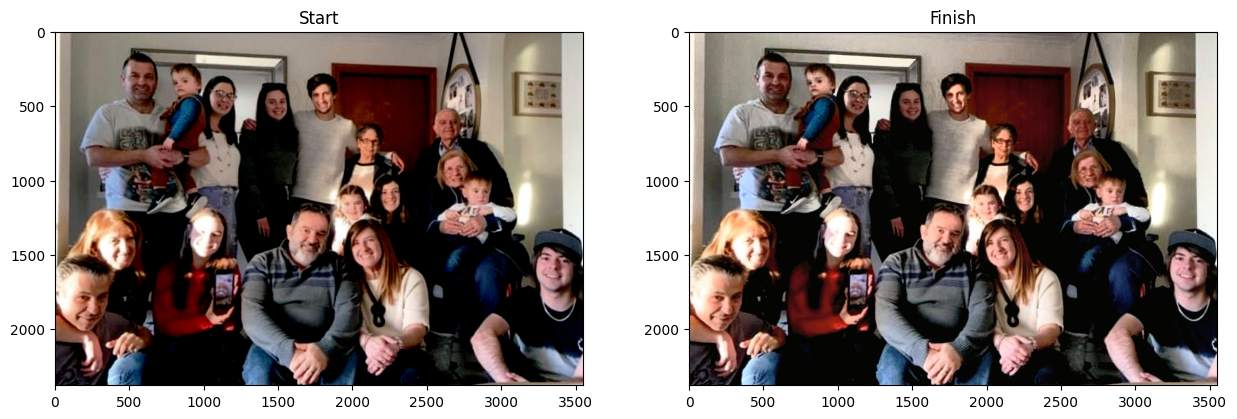

In [897]:
#Start/Fin post save
finpath = 'Images/'+path+'inpainted'+ext
finish = cv.imread(finpath)
finish = cv2.cvtColor(finish, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 2, 1) 
plt.imshow(img_rgb)
plt.title("Start")
fig.add_subplot(1, 2, 2) 
plt.imshow(finish)
plt.title("Finish")